In [1]:
#    This file is part of DEAP.
#    This implements the NSGA-II in an easy way because it makes us of DEAP subroutines
#    The non dominated sort and crowding distance are solved by a simiple call to DEAP subroutines
#    and their implementation is hidden.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import random
import json
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import numpy

from math import sqrt
from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torchvision.__version__

#normalise pixel values (range:-1 to 1, mean:0.5, s.d:0.5)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size=512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

PopModel=Net()
PopModel.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
PATH = ('./40_epoch_32_batch_SGD_net.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))
final_layer = PopModel.classifier[-1]

criterion = nn.CrossEntropyLoss()
nn.init.xavier_uniform(final_layer.weight)

creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
# creator.create("Individual", list, fitness=creator.FitnessMulti)
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMulti)
NDIM = 530
toolbox = base.Toolbox()

BOUND_LOW, BOUND_UP = -5.0, 5.0

<ipython-input-4-b1cd0b88156b>:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(final_layer.weight)


In [5]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [6]:
def evaluateModel():
    runningValLoss=0.0
    total=0.0
    PopModel.eval()
    correct_predictions=0.0
    total_samples=0.0
    correct_predictions=0.0
    # Forward pass to get predictions
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            PopModel.to(device)
            prediction = PopModel(images)
            loss=criterion(prediction, labels)
            runningValLoss=loss.item()
            _, predicted = torch.max(prediction.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100*(correct_predictions / total_samples)
    return accuracy

In [7]:
def calcFitness(individual):
    weights = numpy.square(numpy.array(individual))
    particleweightsNP1 = numpy.array(individual)
    particleweightsNP = particleweightsNP1[:520]
    biases = numpy.array(particleweightsNP1[-10:])
    biases = torch.from_numpy(biases).float()
    final_layer.bias = torch.nn.Parameter(biases.float())

    #converting to the correct shape
    reshapedWeights = particleweightsNP.reshape(10,52)

    #converting to torch array
    torchWeights = torch.from_numpy(reshapedWeights).float()

    #setting the weights of the final layer to these weights
    final_layer.weight = torch.nn.Parameter(torchWeights.float())

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

#     print("Calc for Individual")
    with torch.no_grad():
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            PopModel.to(device)
            outputs = PopModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    accuracy = 100*(correct_predictions / total_samples)
#     print(f"For entire training set, total samples: {total_samples}, correct predictions: {correct_predictions}, accuracy: {accuracy}")
    regularizer = numpy.sum(weights)

    return accuracy, regularizer    

In [8]:
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", calcFitness)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)

In [9]:
def main(seed=None):
    random.seed(seed)

    NGEN = 100
    MU =  100
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)
    
    #evaluating the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    print("Evaluate fitnesses before generation loop..")
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    #assigning crowding distance to the individuals
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    #beginning the generational process
    for gen in range(1, NGEN):
        #vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        #making pairs of all (even,odd) in offspring
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        #evaluating the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#         print(f"Evaluate fitnesses at {NGEN} generation..")
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
#             print(f"Fitness for individual is {fit}")
            ind.fitness.values = fit

        #selecting the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, logbook

In [10]:
if __name__ == "__main__":
    pop, stats = main()
    # Clone a all individual from a current popoulation
    popclone = list(map(toolbox.clone, pop))

    pop.sort(key=lambda x: x.fitness.values)
    
    # print some individuals
    for n in range(10):
        i=pop[random.choice(range(0, len(pop)))]
        x1=i[0:4]
        x2=i[4:7]
        x3=i[7:9]
        x1= int("".join(str(i) for i in x1),2)
        x2= int("".join(str(i) for i in x2),2)
        x3= int("".join(str(i) for i in x3),2)
        print(x1,x2,x3)
    
    # get a first non dominate individuals in all an optimal solutions
    first_front = tools.sortNondominated(individuals=popclone,k=len(popclone), first_front_only=True)[0]
    best_weights = first_front[0]
    # sort each individual by its ftiness values
    first_front.sort(key= lambda x: x.fitness.values)
    popclone.sort(key = lambda x: x.fitness.values)

    # get both fitness values of each individual in an array
    # all individual
    all_fronts = numpy.array([ind.fitness.values for ind in popclone])
    # Non dominated individual
    first_front = numpy.array([ ind.fitness.values for ind in first_front])


    fig , (ax) = plt.subplots(ncols=1, nrows=1)
    ax.scatter(all_fronts[:,0], all_fronts[:,1], c='b', marker='x')
    ax.scatter(first_front[:,0], first_front[:,1], s=150, facecolor='none', edgecolors='g', linewidths=2)
    ax.plot(first_front[:,0], first_front[:,1], c='r', linestyle='dashdot')
    ax.set_title("NSGA II Pareto front")
    ax.set_xlabel('Accuracy (objective 1)')
    ax.set_ylabel("Regulariser (objective 2)")
    ax.grid()
    #plt.axis("tight")
    figure = ax.get_figure()
    plt.show()

    #set the weights in the model
    weights = numpy.square(numpy.array(best_weights))
    particleweightsNP1 = numpy.array(best_weights)
    particleweightsNP = particleweightsNP1[:520]
    biases = numpy.array(particleweightsNP1[-10:])
    biases = torch.from_numpy(biases).float()
    final_layer.bias = torch.nn.Parameter(biases.float())

    # Convert to the correct shape
    reshapedWeights = particleweightsNP.reshape(10,52)

    # Convert to torch array
    torchWeights = torch.from_numpy(reshapedWeights).float()

    # Set the weights of the final layer to these weights
    final_layer.weight = torch.nn.Parameter(torchWeights.float())

    #evaluate the model
    accuracy = evaluateModel()

    print("Test Accuracy: ", accuracy)

Evaluate fitnesses before generation loop..
gen	evals	std                        	min                          	avg                          	max                          
0  	100  	[  2.94189173 179.54944989]	[   4.302      3952.97402828]	[  10.28262    4428.98695016]	[  17.724      4818.74685587]
1  	100  	[  2.96027118 191.42871438]	[3.44800000e+00 3.90381019e+03]	[  12.10872    4319.51099023]	[  18.196      4755.82530802]
2  	100  	[  3.25750861 230.42747976]	[3.43400000e+00 3.81438002e+03]	[  13.17574    4247.54872914]	[  19.184      4810.50625385]
3  	100  	[  3.85372969 241.65451969]	[3.38600000e+00 3.77681698e+03]	[  13.91142    4165.52429509]	[  21.336      4810.50625385]
4  	100  	[  3.98427948 266.37860562]	[3.43400000e+00 3.46416149e+03]	[  14.87428    4112.02512219]	[  21.558     4760.3794049]  
5  	100  	[  3.86171842 275.02854739]	[   6.338      3464.16149306]  	[  16.08026    4066.36548356]	[  22.994      4631.06132047]
6  	100  	[  3.51207133 288.17699938]	[   9.272   

ValueError: invalid literal for int() with base 2: '-0.611792444713691-0.35680664999299394-2.24530157395621370.09654670793809715'

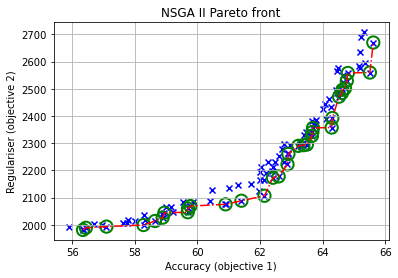

Test Accuracy:  72.46000000000001


In [11]:
# get a first non dominate individuals in all an optimal solutions
first_front = tools.sortNondominated(individuals=popclone,k=len(popclone), first_front_only=True)[0]
best_weights = first_front[0]
# sort each individual by its ftiness values
first_front.sort(key= lambda x: x.fitness.values)
popclone.sort(key = lambda x: x.fitness.values)

# get both fitness values of each individual in an array
# all individual
all_fronts = numpy.array([ind.fitness.values for ind in popclone])
# Non dominated individual
first_front = numpy.array([ ind.fitness.values for ind in first_front])


fig , (ax) = plt.subplots(ncols=1, nrows=1)
ax.scatter(all_fronts[:,0], all_fronts[:,1], c='b', marker='x')
ax.scatter(first_front[:,0], first_front[:,1], s=150, facecolor='none', edgecolors='g', linewidths=2)
ax.plot(first_front[:,0], first_front[:,1], c='r', linestyle='dashdot')
ax.set_title("NSGA II Pareto front")
ax.set_xlabel('Accuracy (objective 1)')
ax.set_ylabel("Regulariser (objective 2)")
ax.grid()
#plt.axis("tight")
figure = ax.get_figure()
plt.show()

#set the weights in the model
weights = numpy.square(numpy.array(best_weights))
particleweightsNP1 = numpy.array(best_weights)
particleweightsNP = particleweightsNP1[:520]
biases = numpy.array(particleweightsNP1[-10:])
biases = torch.from_numpy(biases).float()
final_layer.bias = torch.nn.Parameter(biases.float())

# Convert to the correct shape
reshapedWeights = particleweightsNP.reshape(10,52)

# Convert to torch array
torchWeights = torch.from_numpy(reshapedWeights).float()

# Set the weights of the final layer to these weights
final_layer.weight = torch.nn.Parameter(torchWeights.float())

#evaluate the model
accuracy = evaluateModel()

print("Test Accuracy: ", accuracy)

In [12]:
gen = stats.select("gen")
evals = stats.select("evals")
std = stats.select("std")
avg = [x[0] for x in stats.select("avg")]
min_fit = [x[0] for x in stats.select("min")]
max_fit = [x[0] for x in stats.select("max")]

csv_filename = "training_log_6.csv"

with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["gen", "evals", "std", "min", "avg", "max"])
    csv_writer.writerows(zip(gen, evals, std, min_fit, avg, max_fit))

print(f"Logbook exported to {csv_filename}")

Logbook exported to training_log_6.csv


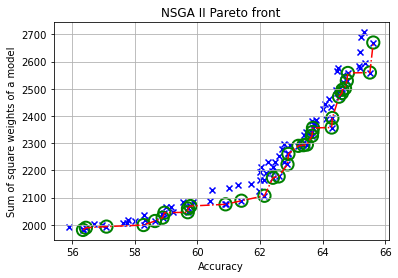

In [13]:
fig , (ax) = plt.subplots(ncols=1, nrows=1)
ax.scatter(all_fronts[:,0], all_fronts[:,1], c='b', marker='x')
ax.scatter(first_front[:,0], first_front[:,1], s=150, facecolor='none', edgecolors='g', linewidths=2)
ax.plot(first_front[:,0], first_front[:,1], c='r', linestyle='dashdot')
ax.set_title("NSGA II Pareto front")
ax.set_xlabel('Accuracy')
ax.set_ylabel("Sum of square weights of a model")
ax.grid()
#plt.axis("tight")
figure = ax.get_figure()
plt.show()
figure.savefig("nsga-front.pdf", bbox_inches='tight')
figure.savefig("nsga-front.png", dpi=300, bbox_inches='tight')

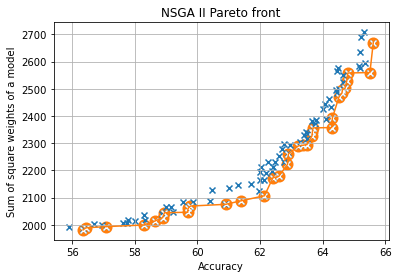

In [46]:
fig , (ax) = plt.subplots(ncols=1, nrows=1)
ax.plot(first_front[:,0], first_front[:,1], c='tab:orange', linestyle='solid')
ax.scatter(first_front[:,0], first_front[:,1], s=100, facecolor='tab:orange', edgecolors='tab:orange', linewidths=2)
ax.scatter(all_fronts[:,0], all_fronts[:,1], marker='x')
ax.scatter(first_front[:,0], first_front[:,1], marker='x', facecolor='w')
ax.set_title("NSGA II Pareto front")
ax.set_xlabel('Accuracy')
ax.set_ylabel("Sum of square weights of a model")
ax.grid()
#plt.axis("tight")
figure = ax.get_figure()
plt.show()
figure.savefig("nsga-front.pdf", bbox_inches='tight')
figure.savefig("nsga-front.png", dpi=300, bbox_inches='tight')

In [14]:
print("All fronts, ", all_fronts)
print("First front, ", first_front)

All fronts,  [[  55.892      1993.69961149]
 [  56.33       1984.02458522]
 [  56.342      1981.3523992 ]
 [  56.434      1989.09409016]
 [  56.688      2002.49617831]
 [  56.954      1999.69004427]
 [  57.092      1993.54309443]
 [  57.612      2006.10768081]
 [  57.736      2006.10768081]
 [  57.766      2019.54011149]
 [  58.002      2014.52725049]
 [  58.276      1999.32679409]
 [  58.29       2037.14179261]
 [  58.312      2018.98498038]
 [  58.642      2014.07663255]
 [  58.854      2038.0170808 ]
 [  58.888      2026.44549995]
 [  58.944      2044.42816392]
 [  59.006      2064.16590427]
 [  59.168      2066.07797527]
 [  59.208      2047.39948041]
 [  59.544      2084.27711252]
 [  59.69       2046.35787264]
 [  59.698      2060.14151659]
 [  59.754      2069.9944291 ]
 [  59.776      2069.06911458]
 [  59.85       2084.29109472]
 [  60.412      2086.06322889]
 [  60.454      2126.20277799]
 [  60.894      2077.72052483]
 [  60.898      2075.37305853]
 [  61.002      2135.62290

In [ ]:
csv_all_fronts = "all_fronts.csv"

with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
#     csv_writer.writerow(["gen", "evals", "std", "min", "avg", "max"])
    csv_writer.writerows(all_fronts)

print(f"Logbook exported to {csv_all_fronts}")

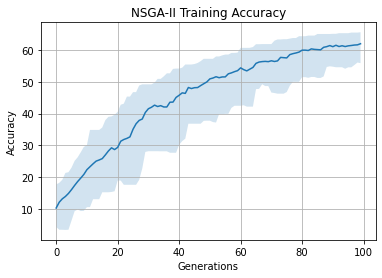

In [48]:
graphEpochCounter = range(100)
fig , (ax) = plt.subplots(ncols=1, nrows=1)
ax.fill_between(graphEpochCounter, min_fit, max_fit, alpha=0.2)
ax.plot(graphEpochCounter, avg)
ax.set_title("NSGA-II Training Accuracy")
ax.set_xlabel('Generations')
ax.set_ylabel("Accuracy")
ax.grid()
figure = ax.get_figure()
plt.show()
figure.savefig("nsga-accuracy.pdf", bbox_inches='tight')
figure.savefig("nsga-accuracy.png", dpi=300, bbox_inches='tight')